# PLANTILLA PRESELECCIÓN DE VARIABLES

## IMPORTAR PAQUETES

In [35]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance


#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

Cargamos JSON.DATA

In [36]:
# Obtener la ruta del directorio raíz
directorio_raiz = os.getcwd()

# Nombre del archivo JSON
nombre_archivo = "data.json"

# Ruta completa del archivo JSON
ruta_archivo = os.path.join(directorio_raiz, nombre_archivo)

# Abrir el archivo en modo lectura
with open(ruta_archivo, "r") as archivo:
    # Cargar el contenido del archivo JSON
    data = json.load(archivo)

Nombres de los ficheros de datos.

- nombre_df = 'df_tablon.pickle'

Cargar los datos.

In [37]:
df = pd.read_pickle(data['ruta_proyecto'] + '/02_Datos/03_Trabajo/' + 'df_tablon.pickle')

## MÉTODOS SUPERVISADOS

### Preparar x e y

In [38]:
x = df.drop(columns = ['age','rings']).copy()
y =  df['age'].copy()

#Quitamos la variables rings

### Mutual Information

#### Crear una función para mostrar el resultado

In [39]:
def ranking_mi(mutual_selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return(ranking_mi)
    else:
        g = ranking_mi.importancia_mi.sort_values().plot.barh(figsize = (12,5))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importancia_mi').variable)
        return(g)

#### Calcular y revisar

---- Ranking Variables ----

         variable  importancia_mi  ranking_mi
6    shell_weight        0.437444           0
1        diameter        0.412837           1
3    whole_weight        0.406760           2
2          height        0.389648           3
0          length        0.382805           4
5  viscera_weight        0.382313           5
4  shucked_weight        0.350579           6
8           sex_I        0.166240           7
7           sex_F        0.050382           8
9           sex_M        0.038576           9

Gráfico Variables



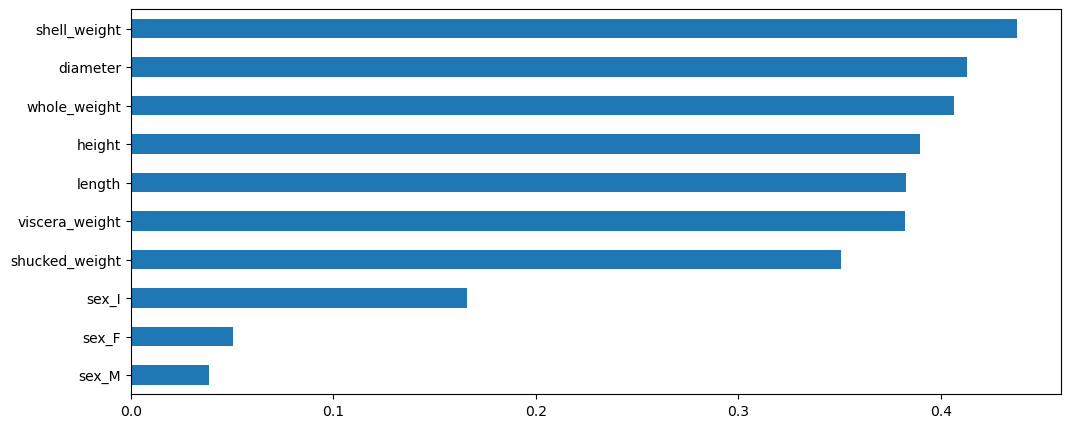

In [40]:
mutual_selector = mutual_info_regression(x,y)

rank_mi = ranking_mi(mutual_selector, modo = 'grafico')
tabla_mi = ranking_mi(mutual_selector, modo = 'tabla')

print('---- Ranking Variables ----\n')
print(tabla_mi)
print('\nGráfico Variables\n')

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [41]:
posicion_variable_limite = 10

##### Extraer los nombres de las que entran

In [42]:
entran_mi = ranking_mi(mutual_selector).iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [43]:
x_mi = x[entran_mi].copy()

### Recursive Feature Elimination

#### Instanciar

In [44]:
rfe = RFE(estimator = XGBRegressor(use_label_encoder=False, n_jobs = -1, eval_metric='mape'))

#### Entrenar

In [45]:
rfe.fit(x,y)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, early_stopping_rounds=None,
                           enable_categorical=False, eval_metric='mape',
                           feature_types=None, gamma=None, gpu_id=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=-1, num_parallel_tree=None, predictor=None,
                           random_state=None, ...))

##### Extraer los nombres de las que entran

In [46]:
entran_rfe = x.columns[rfe.support_]

In [47]:
print(entran_rfe)
print('Nº de variables', len(entran_rfe))

Index(['shucked_weight', 'shell_weight', 'sex_F', 'sex_I', 'sex_M'], dtype='object')
Nº de variables 5


#### Crear el dataframe con la selección

In [48]:
x_rfe = x[entran_rfe].copy()
x_rfe

,shucked_weight,shell_weight,sex_F,sex_I,sex_M
0,0.2245,0.1500,0.0,0.0,1.0
1,0.2565,0.2100,1.0,0.0,0.0
2,0.0895,0.0550,0.0,1.0,0.0
3,0.1410,0.1200,0.0,1.0,0.0
4,0.2370,0.3300,1.0,0.0,0.0
...,...,...,...,...,...
2898,0.4000,0.2290,0.0,0.0,1.0
2899,0.4390,0.2605,0.0,0.0,1.0
2900,0.5255,0.3080,0.0,0.0,1.0
2901,0.5310,0.2960,1.0,0.0,0.0


### Permutation Importance

#### Crear una función para mostrar el resultado

In [49]:
def ranking_per(predictoras,permutacion):
    ranking_per = pd.DataFrame({'variable': predictoras.columns, 'importancia_per': permutacion.importances_mean}).sort_values(by = 'importancia_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instanciar y entrenar

In [50]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBRegressor(use_label_encoder=False, n_jobs = -1, eval_metric='mae' )

xgb.fit(x,y)

permutacion = permutation_importance(xgb, 
                                     x, y, 
                                     scoring='neg_mean_absolute_percentage_error',
                                     n_repeats=5, n_jobs = -1)

#### Revisar la salida

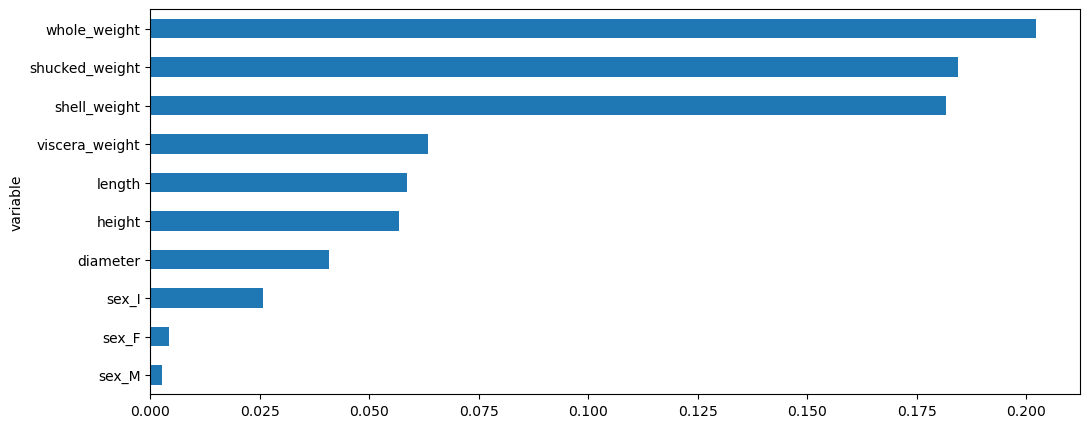

In [51]:
rank_per = ranking_per(x,permutacion)

rank_per.set_index('variable').importancia_per.sort_values().plot.barh(figsize = (12,5));

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [52]:
posicion_variable_limite = 6

##### Extraer los nombres de las que entran

In [53]:
entran_per = rank_per.iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [54]:
x_per = x[entran_per].copy()

## SELECCIONAR EL MÉTODO FINAL

Descomentar el método de preselección elegido y dejar comentados el resto.

In [55]:
x_preseleccionado = x_mi
# x_preseleccionado = x_rfe
# x_preseleccionado = x_per

## MÉTODOS NO SUPERVISADOS

### Correlación

#### Crear una función para mostrar el resultado

In [56]:
def correlaciones_fuertes(df, lim_inf = 0.3, lim_sup = 1,drop_dupli=True):
    #Calcula la matriz de correlación
    c = df.corr().abs()
    #Lo pasa todo a filas
    c= c.unstack()
    #Pasa el índice a columnas y le pone nombres
    c = pd.DataFrame(c).reset_index()
    c.columns = ['var1','var2','corr']
    #A dataframe, filtra limites y ordena en descendiente
    c = c.loc[(c['corr'] > lim_inf) &  (c['corr'] < lim_sup),:].sort_values(by = 'corr', ascending=False)
    #Desduplica las correlaciones (o no si drop_dupli es False)
    c = c if drop_dupli == False else c.drop_duplicates(subset = ['corr'])
    #Devuelve la salida
    return(c)

#### Calcular y revisar

##### Calcular

In [57]:
cor_finales = correlaciones_fuertes(x_preseleccionado)

##### Revisar agregado

In [58]:
cor_finales.var1.value_counts()

shell_weight      5
viscera_weight    5
height            5
length            4
sex_I             4
sex_F             4
shucked_weight    3
whole_weight      3
diameter          2
Name: var1, dtype: int64

In [59]:
x_preseleccionado.columns.to_list()

['shell_weight',
 'diameter',
 'whole_weight',
 'height',
 'length',
 'viscera_weight',
 'shucked_weight',
 'sex_I',
 'sex_F',
 'sex_M']

Según la correlación de las variables eliminaremos las siguientes:

['diameter',
 'whole_weight',
 'viscera_weight',
 'shucked_weight',
 'sex_F',
 'sex_M']

##### Revisar detalle

In [60]:
cor_finales.head(50)

,var1,var2,corr
41,length,diameter,0.986637
62,shucked_weight,whole_weight,0.971049
25,whole_weight,viscera_weight,0.968079
2,shell_weight,whole_weight,0.958758
56,viscera_weight,shucked_weight,0.934160
42,length,whole_weight,0.925689
21,whole_weight,diameter,0.925172
5,shell_weight,viscera_weight,0.916260
10,diameter,shell_weight,0.912441
13,diameter,height,0.909942


#### Filtrar variables

Meter en una lista las que queramos descartar por alta correlacion y eliminarlas.

In [62]:
a_eliminar_corr = ['diameter',
                    'whole_weight',
                    'viscera_weight',
                    'shucked_weight',
                    'sex_F',
                    'sex_M']

In [63]:
x_preseleccionado.drop(columns = a_eliminar_corr, inplace = True)

In [64]:
x_preseleccionado.columns.to_list()

['shell_weight', 'height', 'length', 'sex_I']

## GUARDAR DATASETS TRAS PRESELECCION DE VARIABLES

In [65]:
#Definir los nombres de los archivos
nombre_x_preseleccionado = data['ruta_proyecto'] + '/02_Datos/03_Trabajo/' + 'x_preseleccionado.pickle'
nombre_y_preseleccionado =  data['ruta_proyecto'] + '/02_Datos/03_Trabajo/' + 'y_preseleccionado.pickle'

In [66]:
#Guardar los archivos
x_preseleccionado.to_pickle(nombre_x_preseleccionado)

y_preseleccionado = y.copy()
y_preseleccionado.to_pickle(nombre_y_preseleccionado)

In [67]:
#Guardar los nombres de las variables finales
nombre_variables_finales = data['ruta_proyecto'] + '/05_Resultados/' + 'variables_finales.pickle'

x_preseleccionado.iloc[0].to_pickle(nombre_variables_finales)